# Oak Wilt Severity & Risk Modeling (Hurricane Warning Approach)

This model predicts a **"Cone of Uncertainty"** for the spread radius of Oak Wilt clusters, similar to hurricane path warnings. Instead of a single number, we predict three severity levels to help arborists make risk-informed decisions:

- **Conservative Estimate (10th percentile):** The minimum likely spread. Trees within this radius are almost certainly infected.
- **Expected Spread (50th percentile):** The most likely radius of the infection center.
- **Severe Case (90th percentile):** The worst-case scenario. Trees out to this radius are at high risk and should be monitored or treated preventively.

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path

cluster_features_path = Path('../data/oak_wilt_cluster_features.csv')
cluster_members_path = Path('../data/oak_wilt_cluster_members.csv')

cluster_features = pd.read_csv(cluster_features_path)
cluster_members = pd.read_csv(cluster_members_path)

cluster_features['radius_ft'] = cluster_features['radius_km'] * 3280.84
cluster_features['spread_ft_per_year'] = cluster_features['spread_rate_km_per_year'] * 3280.84

# STRICT FILTERING: Drop clusters smaller than ~65ft (0.02km) radius to remove noise
print(f"Original cluster count: {len(cluster_features)}")
cluster_features = cluster_features[cluster_features['radius_km'] >= 0.02].reset_index(drop=True)
print(f"Filtered cluster count: {len(cluster_features)}")

cluster_features

Original cluster count: 79
Filtered cluster count: 68


,cluster_id,original_label,point_count,unique_years,start_year,end_year,year_span,annual_counts,centroid_lat,centroid_lon,...,point_density_per_km2,spread_rate_km_per_year,dominant_species,dominant_landowner,eps_m,temporal_scale_m,min_samples,min_unique_years,radius_ft,spread_ft_per_year
0,1,0,3,2,1989,1990,1,"{""1989"": 1, ""1990"": 2}",30.296167,-97.777288,...,859.629732,0.033330,Live Oak,Unknown,80.0,20.0,3,2,109.349054,109.349054
1,3,4,6,5,1992,1999,7,"{""1992"": 1, ""1993"": 1, ""1995"": 2, ""1997"": 1, ""...",30.245315,-97.825583,...,565.201686,0.008304,Live Oak,Unknown,80.0,20.0,3,2,190.714633,27.244948
2,4,6,4,4,1992,1999,7,"{""1992"": 1, ""1994"": 1, ""1997"": 1, ""1999"": 1}",30.253692,-97.790357,...,482.436985,0.007339,Live Oak,Unknown,80.0,20.0,3,2,168.546529,24.078076
3,6,8,4,2,1995,1998,3,"{""1995"": 3, ""1998"": 1}",30.391900,-97.762879,...,1217.021911,0.010782,Live Oak,Unknown,80.0,20.0,3,2,106.118453,35.372818
4,7,9,6,4,1996,2001,5,"{""1996"": 1, ""1997"": 1, ""2000"": 2, ""2001"": 2}",30.424712,-97.731192,...,2180.338398,0.005919,Live Oak,Unknown,80.0,20.0,3,2,97.101019,19.420204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,74,90,110,3,2017,2019,2,"{""2017"": 24, ""2018"": 45, ""2019"": 41}",30.211066,-97.798941,...,1059.176155,0.090909,Live Oak,Municipal - Parkland,80.0,20.0,3,2,596.516361,298.258181
64,75,92,10,2,2017,2018,1,"{""2017"": 1, ""2018"": 9}",30.231774,-97.756052,...,526.915353,0.077724,Live Oak,Private,80.0,20.0,3,2,254.999711,254.999711
65,76,93,5,3,2016,2018,2,"{""2016"": 1, ""2017"": 2, ""2018"": 2}",30.340800,-97.779810,...,176.695537,0.047453,Live Oak,Unknown,80.0,20.0,3,2,311.373986,155.686993
66,77,97,4,2,2018,2019,1,"{""2018"": 2, ""2019"": 2}",30.192714,-97.801908,...,318.915208,0.063186,Live Oak,Municipal - ROW,80.0,20.0,3,2,207.301524,207.301524


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cluster_features = cluster_features.dropna(subset=['spread_rate_km_per_year']).copy()
cluster_features['log_density'] = np.log1p(cluster_features['point_density_per_km2'])
feature_cols = [
    'point_count',
    'unique_years',
    'year_span',
    'area_km2',
    'log_density',
    'spread_rate_km_per_year'
 ]
X = cluster_features[feature_cols].astype(np.float32)
y_radius = cluster_features['radius_ft'].astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_radius, test_size=0.2, random_state=42
 )

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
y_train = y_train.to_numpy(dtype=np.float32)
y_val = y_val.to_numpy(dtype=np.float32)

X_train_scaled.shape, X_val_scaled.shape

((54, 6), (14, 6))

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e), axis=-1)

def combined_quantile_loss(y_true, y_pred):
    # y_pred has shape (batch, 3) -> [q10, q50, q90]
    q10_loss = quantile_loss(0.1, y_true, y_pred[:, 0:1])
    q50_loss = quantile_loss(0.5, y_true, y_pred[:, 1:2])
    q90_loss = quantile_loss(0.9, y_true, y_pred[:, 2:3])
    return q10_loss + q50_loss + q90_loss

inputs = keras.Input(shape=(X_train_scaled.shape[1],), name='features')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
# Output layer: 3 neurons for 10th, 50th, 90th percentiles
outputs = layers.Dense(3, name='quantiles')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=combined_quantile_loss
 )
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantiles (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627 (10.26 KB)

 Trainable params: 2,627 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
 ]

history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=1000,
    batch_size=8,
    callbacks=callbacks,
    verbose=0
 )

print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

Final Validation Loss: 60.2417


In [18]:
preds = model.predict(X_val_scaled, verbose=0)

results = pd.DataFrame({
    'True_Radius_ft': y_val,
    'Conservative_Min (10%)': preds[:, 0],
    'Expected_Spread (50%)': preds[:, 1],
    'Severe_Case (90%)': preds[:, 2]
})

# Check if true value falls within the 10-90 cone
results['Inside_Cone'] = (results['True_Radius_ft'] >= results['Conservative_Min (10%)']) & \
                         (results['True_Radius_ft'] <= results['Severe_Case (90%)'])

results['Cone_Width_ft'] = results['Severe_Case (90%)'] - results['Conservative_Min (10%)']

print(f"Coverage (Validation): {results['Inside_Cone'].mean():.1%}")
print("\nSample Predictions (Validation Set):")
results.round(1).head(10)

Coverage (Validation): 92.9%

Sample Predictions (Validation Set):


,True_Radius_ft,Conservative_Min (10%),Expected_Spread (50%),Severe_Case (90%),Inside_Cone,Cone_Width_ft
0,113.699997,97.000000,192.100006,373.899994,True,276.799988
1,246.899994,84.400002,166.199997,322.899994,True,238.500000
2,97.099998,71.800003,151.399994,288.399994,True,216.600006
3,154.100006,70.300003,142.800003,275.399994,True,205.199997
4,101.500000,77.500000,156.199997,302.399994,True,224.899994
5,135.300003,92.300003,182.500000,355.399994,True,263.200012
6,104.900002,75.500000,152.500000,295.000000,True,219.500000
7,257.200012,94.599998,201.199997,381.399994,True,286.700012
8,305.700012,48.700001,95.500000,184.899994,False,136.300003
9,153.500000,75.000000,152.199997,293.500000,True,218.600006


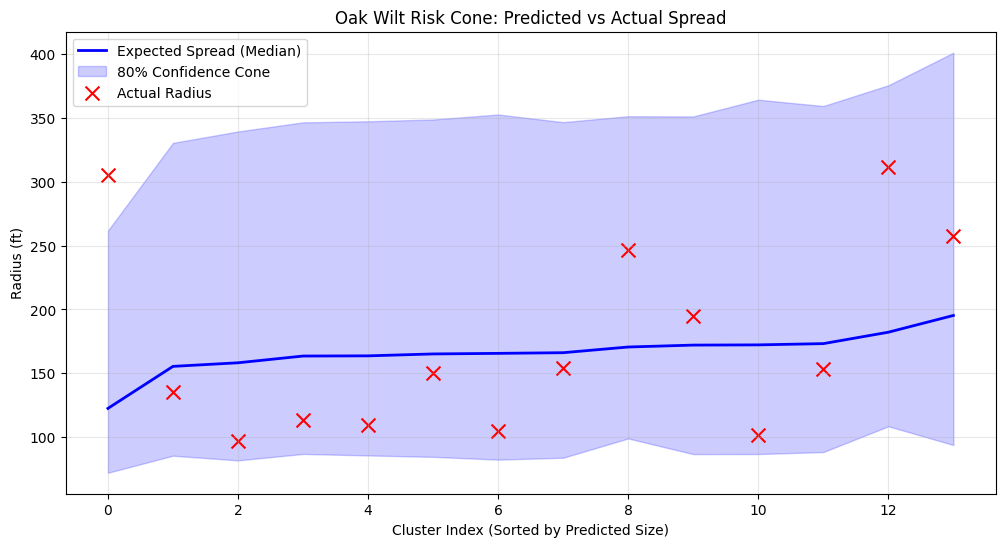

In [12]:
# Visualization of the Risk Cone for Validation Samples
import matplotlib.pyplot as plt

results_sorted = results.sort_values('Expected_Spread (50%)').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(results_sorted.index, results_sorted['Expected_Spread (50%)'], label='Expected Spread (Median)', color='blue', linewidth=2)
plt.fill_between(results_sorted.index, 
                 results_sorted['Conservative_Min (10%)'], 
                 results_sorted['Severe_Case (90%)'], 
                 color='blue', alpha=0.2, label='80% Confidence Cone')

plt.scatter(results_sorted.index, results_sorted['True_Radius_ft'], color='red', marker='x', s=100, label='Actual Radius')

plt.title('Oak Wilt Risk Cone: Predicted vs Actual Spread')
plt.xlabel('Cluster Index (Sorted by Predicted Size)')
plt.ylabel('Radius (ft)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()